# 1. Import dependencies

In [19]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import  Discrete, Box, Dict, MultiBinary, MultiDiscrete
from gymnasium import spaces

#import helpers
import numpy as np
import random
import os


# import stable baselines stuff
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# 2. Types of Spaces

In [2]:
Discrete(3)

Discrete(3)

In [3]:
Discrete(3).sample()

np.int64(0)

In [5]:
Box(0, 1, shape=(3,3)).sample()

array([[0.5632963 , 0.8885268 , 0.082262  ],
       [0.79775405, 0.53255606, 0.8712658 ],
       [0.21169843, 0.05578557, 0.7576014 ]], dtype=float32)

In [12]:
Dict({'position': Discrete(3), 'velocity': Discrete(2)}).sample()

{'position': np.int64(0), 'velocity': np.int64(1)}

In [13]:
MultiBinary(5).sample()

array([1, 1, 1, 0, 1], dtype=int8)

In [14]:
MultiDiscrete([5,2]).sample()

array([1, 0])

In [21]:
spaces.Discrete(11).sample()

np.int64(9)

# 3. Building an Environment

In this scenario, a factory must decide how many units to produce/order each day. If you produce too much, you pay holding costs; if you produce too little, you lose money due to stockouts (unsatisfied demand).

The Manufacturing Scenario: Inventory Control

We will build a environment where:

** Observation: Current stock level.

** Action: How many units to manufacture today.

** Reward: (Items Sold x Profit) - (Stock x Holding Cost) - (Stockouts x Penalty).

In [23]:
class InventoryEnv(gym.Env):
    def __init__(self):
        super(InventoryEnv, self).__init__()

        # Actions: 0 to 10 units produced per day
        self.action_space = spaces.Discrete(11)

        # Observations: Current inventory (0 to 100 units)
        # We use high=100 as a practical limit
        self.observation_space = spaces.Box(low=0, high=100, shape=(1,), dtype=np.int32)

        # Initial state
        self.state = np.array([20], dtype=np.int32) # Start with 20 units
        self.max_steps = 30 # A "month" of simulation
        self.current_step = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([20], dtype=np.int32)
        self.current_step = 0
        return self.state, {}

    def step(self, action):
        # 1. Update Inventory with production (Action)
        self.state[0] += action
        
        # 2. Simulate Random Demand (e.g., 0 to 10 units)
        demand = np.random.randint(0, 11)
        
        # 3. Calculate Reward & Update Stock
        units_sold = min(self.state[0], demand)
        self.state[0] -= units_sold
        
        # Penalties and Profits
        profit = units_sold * 10
        holding_cost = self.state[0] * 2
        stockout_penalty = max(0, demand - units_sold) * 15
        
        reward = profit - holding_cost - stockout_penalty
        
        # 4. Handle Step Logic
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False
        
        # Keep inventory within bounds for observation stability
        self.state[0] = np.clip(self.state[0], 0, 100)

        return self.state, float(reward), terminated, truncated, {}

    def render(self):
        print(f"Step: {self.current_step} | Inventory: {self.state[0]}")

In [24]:
env = InventoryEnv()

In [25]:
env.observation_space.sample()

array([16], dtype=int32)

In [26]:
env.action_space.sample()

np.int64(5)

# 4. Test Environment

In [27]:
episode =5
for episode in range(episode+1):
    obs = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score += reward
    print(f"Episode: {episode} Score: {score}")
env.close()

Step: 0 | Inventory: 20
Step: 1 | Inventory: 20
Step: 2 | Inventory: 27
Step: 3 | Inventory: 17
Step: 4 | Inventory: 16
Step: 5 | Inventory: 12
Step: 6 | Inventory: 9
Step: 7 | Inventory: 13
Step: 8 | Inventory: 16
Step: 9 | Inventory: 23
Step: 10 | Inventory: 21
Step: 11 | Inventory: 18
Step: 12 | Inventory: 13
Step: 13 | Inventory: 7
Step: 14 | Inventory: 2
Step: 15 | Inventory: 0
Step: 16 | Inventory: 0
Step: 17 | Inventory: 0
Step: 18 | Inventory: 1
Step: 19 | Inventory: 8
Step: 20 | Inventory: 8
Step: 21 | Inventory: 8
Step: 22 | Inventory: 7
Step: 23 | Inventory: 7
Step: 24 | Inventory: 9
Step: 25 | Inventory: 7
Step: 26 | Inventory: 15
Step: 27 | Inventory: 15
Step: 28 | Inventory: 18
Step: 29 | Inventory: 18
Episode: 0 Score: 732.0
Step: 0 | Inventory: 20
Step: 1 | Inventory: 19
Step: 2 | Inventory: 21
Step: 3 | Inventory: 14
Step: 4 | Inventory: 15
Step: 5 | Inventory: 14
Step: 6 | Inventory: 7
Step: 7 | Inventory: 9
Step: 8 | Inventory: 10
Step: 9 | Inventory: 7
Step: 10 | In

# 5. Train Model

In [28]:
log_path = os.path.join('Training', 'Logs')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/irfan/miniconda3/envs/RFL_Stable/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [29]:
model.learn(total_timesteps=100000)

Logging to Training/Logs/PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 96.3     |
| time/              |          |
|    fps             | 179      |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 30        |
|    ep_rew_mean          | 281       |
| time/                   |           |
|    fps                  | 157       |
|    iterations           | 2         |
|    time_elapsed         | 26        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0161168 |
|    clip_fraction        | 0.174     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.38     |
|    explained_variance   | -0.000628 |
|    learning_rate        | 0

# 6. Plotting Learning Curve

In [30]:
import os
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter

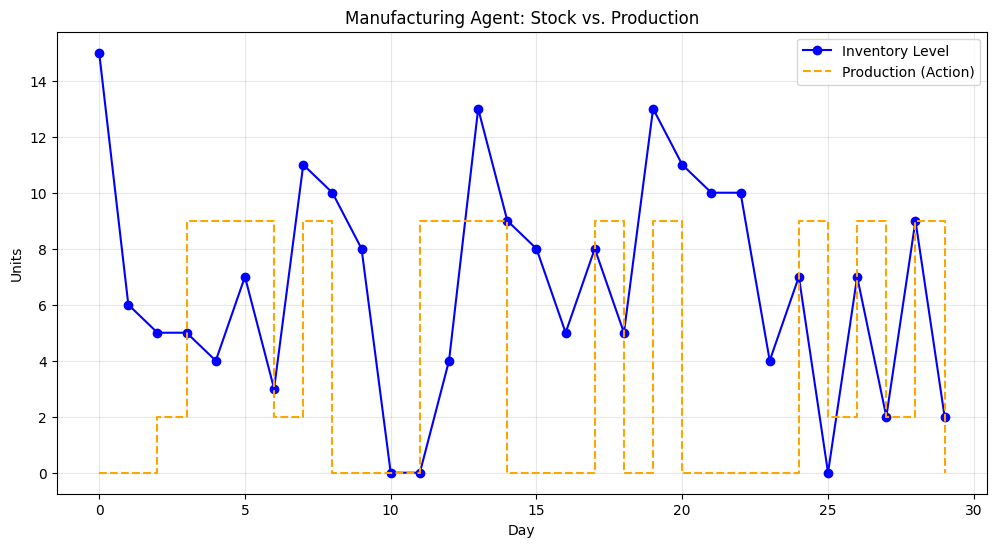

In [31]:
def plot_test_episode(env, model):
    obs, _ = env.reset()
    inventory_history = []
    action_history = []
    rewards = []

    # Run one full episode (30 steps)
    for _ in range(30):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        
        inventory_history.append(obs[0])
        action_history.append(action)
        rewards.append(reward)
        
        if terminated or truncated:
            break

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot Inventory and Production
    plt.plot(inventory_history, label='Inventory Level', color='blue', marker='o')
    plt.step(range(len(action_history)), action_history, label='Production (Action)', color='orange', where='post', linestyle='--')
    
    plt.title('Manufacturing Agent: Stock vs. Production')
    plt.xlabel('Day')
    plt.ylabel('Units')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the plotting function
plot_test_episode(env, model)

# 7. Save Model

In [33]:
inventory_path = os.path.join('Training', 'Saved_Models', 'Inventory_Model_PPO')

In [34]:
model.save(inventory_path)

In [35]:
del model

In [36]:
model = PPO.load(inventory_path, env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/irfan/miniconda3/envs/RFL_Stable/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [37]:
evaluate_policy(model, env, n_eval_episodes=10, render=True)

/home/irfan/miniconda3/envs/RFL_Stable/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/irfan/miniconda3/envs/RFL_Stable/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:259: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


(np.float64(1148.2), np.float64(189.109915128742))